::: {.hidden}
$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\mX}{\mathbf{X}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\bracket}[1]{\langle #1 \rangle}
\newcommand{\paren}[1]{\left( #1 \right)}
\newcommand{\one}[1]{\mathbb{1}\left[ #1 \right]}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
$$

:::

In this lecture, we'll study one of the oldest machine learning algorithms: the perceptron. Invented in 1943 but not actually implemented in hardware until 1958, the perceptron is still relevant today as a fundamental building-block of modern deep neural networks. Indeed, one of the implementations of neural networks in `scikit-learn` is still called the "[multilayer perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)." 

When first announced, the perceptron algorithm also displayed one of the first examples of [AI Hype®](https://criticalai.org/the-ai-hype-wall-of-shame/). The *New York Times* uncritically repeated claims by a Navy rep that the perceptron algorithm would be the "embryo" of a computer that would "walk, talk, see, write, reproduce itself, and be conscious of its existence." As we study and implement the perceptron, you may wish to reflect on what you are doing and decide for yourself whether you believe that you are building the "embryo" of any such capabilities yourself.






::: {.column-margin}
![A headline from the New York Times: "New Navy Device Learns By Doing: Psychologist Shows Embryo of Computer Designed to Read and Grow Wiser."](../assets/img/figs/perceptron-nyt.jpeg){#fig-nyt}
Early AI Hype. 
:::


### Our Data

The perceptron algorithm aims to find a rule for separating two distinct groups in some data. Here's an example of some data on which we might aim to apply the perceptron: 

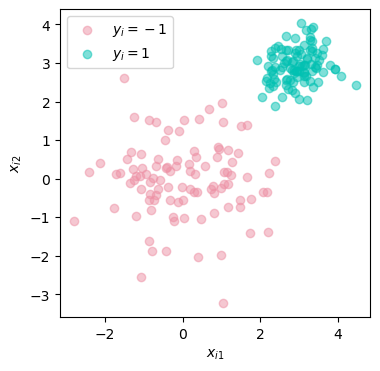

In [1]:
#| fig-cap: "200 data points in the 2d plane, each of which has one of two labels."
#| fig-cap-location: margin
#| label: fig-scatter

import numpy as np
from matplotlib import pyplot as plt
from hidden.perceptron import perceptron_update, draw_line

np.random.seed(123)

plt.rcParams["figure.figsize"] = (4, 4)

X1 = np.random.normal(0, 1, 100)
X2 = np.random.normal(0, 1, 100)

X3 = np.random.normal(0, 1, 100)*.5+3
X4 = np.random.normal(0, 1, 100)*.5+3

fig, ax = plt.subplots(1, 1)

def plot_scatter(X1, X2, X3, X4, ax, legend = True):
    
    s = ax.scatter(X1, X2, color = "#ED90A4", alpha = 0.5, label = r"$y_i = -1$")
    s = ax.scatter(X3, X4, color = "#00C1B2", alpha = 0.5, label = r"$y_i = 1$")
    l = ax.set(xlabel = r"$x_{i1}$")
    l = ax.set(ylabel = "$x_{i2}$")
    if legend:
        l = ax.legend()
    
plot_scatter(X1, X2, X3, X4, ax)

There are 200 points of data. Each data point $i$ has three pieces of information associated with it: 

- A *feature* $x_{i1}$. Think of a feature as a number you can measure, like a someone's height or interest in studying machine learning on a scale. 
- A second feature $x_{i2}$. We often collect all the features associated with a data point $i$ into a *feature vector* $\mathbf{x}_i$. In this case, $\mathbf{x}_i = (x_{i1}, x_{i2}) \in \R^2$.  We often further collect all the feature vectors into a *feature matrix* $\mX$, by stacking all the feature vectors on top of each other: 
$$
\mX = \left[\begin{matrix} & - & \vx_1 & - \\ 
& - & \vx_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \vx_{200} & - \end{matrix}\right]
$$
- A *target variable* $y_i$. In this data set, the target variable is has components equal to either $-1$ or $1$. [In many applications we assume that the target variable has values in $\{0, 1\}$. For the perceptron, it turns out to be extra convenient to use $\{-1, 1\}$ instead.]{.aside} You can think of it as representing a piece of yes-no information like whether a student is a computer science major or not. The target variables can be collected into a *target vector* $\vy = (y_1, \ldots, y_{200})^T \in \{-1,1\}^{200}$. 

More generally, supervised prediction problems with $n$ data points and $k$ features can be summarized in terms of a *feature matrix* $\mX \in \R^{n \times p}$ and a *target vector* $\vy \in \R^n$.

### Linear Classifiers

The idea of a linear classifier is that we seek a *hyperplane* that approximately divides the data into its two classes. A hyperplane in $\R^p$ is an *affine subspace of dimension $\R^{p-1}$*. Such a hyperplane can be specified as the set of vectors $\vx \in \R^p$ satisfying the equation 

$$
\bracket{\vw, \vx} - b = \sum_{i = 1}^p w_i x_i - b = 0
$$ {#eq-hyperplane-1}

for some vector of *weights* $\vw \in \R^p$ and *bias* $b \in R$. For mathematical convenience, it's nicer to write this equation as 

$$
\bracket{\tilde{\vw}, \tilde{\vx}} = 0\;,
$$ {#eq-hyperplane}

where we have defined the new feature vectors $\tilde{\vx} = (\vx, 1)$ and $\tilde{\vw} = (\vw, -b)$. 


When $k = 2$, a hyperplane is just a line. Here are two candidate hyperplanes that we could use to classify our data. Which one looks like it better separates the two classes? 


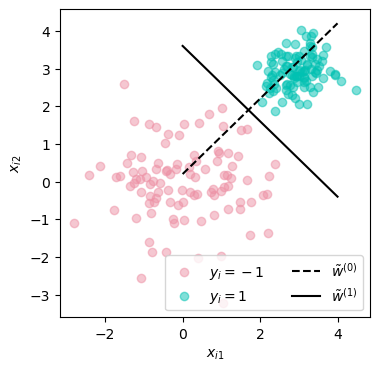

In [2]:
#| fig-cap: Two candidate separating hyperplanes for our data. Which one would you choose? The two weight vectors are $\tilde{\vw}^{(0)} = (0.5, -0.5, 0.1)$ and $\tilde{\vw}^{(1)} = (-0.5, -0.5, 0.9)$. 
#| fig-cap-location: margin
#| label: fig-scatter-with-separators

fig, ax = plt.subplots(1, 1)
p = plot_scatter(X1, X2, X3, X4, ax)

w_0 = np.array([.5, -.5, .1]) 
w_1 = np.array([-.5, -0.5, 1.8])

draw_line(w_0, 0, 4, ax, color = "black", linestyle = "dashed", label = r"$\tilde{w}^{(0)}$")
draw_line(w_1, 0, 4, ax, color = "black", label = r"$\tilde{w}^{(1)}$")


l = ax.legend(ncol = 2)

Whereas the weight vector $\tilde{\vw}^{(0)}$ generates a hyperplane that has data points from both classes on either side of it, the vector $\tilde{\vw}^{(1)}$ *exactly separates* the two classes. What does it mean to exactly separate the two classes? It means that: 

$$
\bracket{\tilde{\vw}^{(1)}, \tilde{\vx}_i} > 0 \Leftrightarrow y_i = 1\;. 
$$ {#eq-perceptron-predict}

That is, if someone gave you the weight vector $\tilde{\vw}^{(1)}$, ***you wouldn't need to see the data labels***: you could exactly recover them using @eq-perceptron-predict. 

Let's make this a little more precise. For fixed $\tilde{\vw}$, let $\hat{y}_i \triangleq \langle \tilde{\vw}, \tilde{\vx}_i \rangle$. The classification *accuracy* of the two-label perceptron with weight $\tilde{\vw}$is 

[We've used a little math trick here: take a moment to convince yourself that @eq-perceptron-predict is equivalent to the statement that $\hat{y}_i y_i > 0$.]{.aside}

$$A(\tilde{\vw}) \triangleq \frac{1}{n} \sum_{i = 1}^n \one{\hat{y}_i y_i > 0}\;.$$

Higher accuracy means that the vector $\tilde{\vw}$ predicts more correct labels via @eq-perceptron-predict. The *loss* (also called the *empirical risk*) is  

$$
R(\tilde{\vw}) \triangleq 1 - A(\tilde{\vw})\;.
$$ {#eq-loss}

It's customary in machine learning to work with the loss. Since we want the accuracy to be high, we want the loss to be small. In other words, we want to *minimize* the function $R$ with respect to the parameters $\vw$ and $b$. 

### The Perceptron Algorithm

The perceptron algorithm doesn't aim to find *the best* $\tilde{\vw}$  (for reasons we'll discuss later, this is not generally possible). Instead, the perceptron aims to find a *good* $\tilde{\vw}$ using the following algorithm: 

1. Start with a *random* $\tilde{\vw}^{(0)}$. 
2. "Until we're done," in each time-step $t$, 
    - Pick a random data point $i \in [n]$. 
    - Compute $\hat{y}^{(t)}_i = \bracket{\tilde{\vw}^{(t)}, \tilde{\vx}_i}$. 
    - If $\hat{y}^{(t)}_i y_i > 0$, then point $i$ is currently correctly classified -- do nothing! 
    - Else, if $\hat{y}^{(t)}_i y_i < 0$, then perform the update 
    $$\tilde{\vw}^{(t+1)} = \tilde{\vw}^{(t)} + y_i \tilde{\vx}_i\;.$$ {#eq-perceptron-update}

#### Local Improvement on Data Point $i$

Let's first check that the perceptron update in @eq-perceptron-update actually improves the prediction on data point $i$ if there is currently a mistake on that point (i.e. if $\hat{y}^{(t)}_i y_i < 0$). We can do this by computing the new $\hat{y}_i^{(t+1)}$. Remember, what we want is for the sign of $\hat{y}_i^{(t+1)}$ to match $y_i$. 

$$
\begin{align}
\hat{y}_i^{(t+1)} &= \bracket{\tilde{\vw}^{(t+1)}, \tilde{\vx}_i}  \tag{definition of $\hat{y}_i^{(t+1)}$}\\ 
               &= \bracket{\tilde{\vw}^{(t)} + y_i\tilde{\vx}_i, \tilde{\vx}_i} \tag{perceptron update} \\ 
               &= \bracket{\tilde{\vw}^{(t)},\tilde{\vx}_i} + y_i\bracket{\tilde{\vx}_i, \tilde{\vx}_i} \tag{linearity of $\bracket{\cdot}$}\\ 
               &= \hat{y}_i^{(t)} + y_i \norm{\tilde{\vx}_i}_2^2\;. \tag{definition of $\hat{y}_i^{(t)}$ and $\norm{\tilde{\vx}_i}$} 
\end{align}
$$

[Again, this is only if $\hat{y}^{(t)}_i y_i < 0$; otherwise there is no change in $\hat{y}_i^{(t)}$ in the current iteration.]{.aside}
Since $\norm{\tilde{\vx}_i} > 0$, we conclude that $\hat{y}_i$ always moves in the right direction: if $y_i = 1$ then $\hat{y}_i^{(t+1)} > \hat{y}_i^{(t)}$, while if $y_i = -1$ then $\hat{y}_i^{(t+1)} < \hat{y}_i^{(t)}$. 

## Illustration

Now let's go ahead and run the perceptron algorithm on some data. First we should set up our feature matrix $\mX$ and target vector $\vy$. 

In [3]:
X = np.append(np.column_stack((X1, X2)), np.column_stack((X3, X4)), axis = 0) # feature matrix
y = 2*(np.arange(0, 200) >= 100) - 1 # target vector

Here are the first few rows of the feature matrix: 

In [4]:
X[0:5, :]

array([[-1.0856306 ,  0.64205469],
       [ 0.99734545, -1.97788793],
       [ 0.2829785 ,  0.71226464],
       [-1.50629471,  2.59830393],
       [-0.57860025, -0.02462598]])

And here are the corresponding values of the target vector: 

In [5]:
y[0:5]

array([-1, -1, -1, -1, -1])

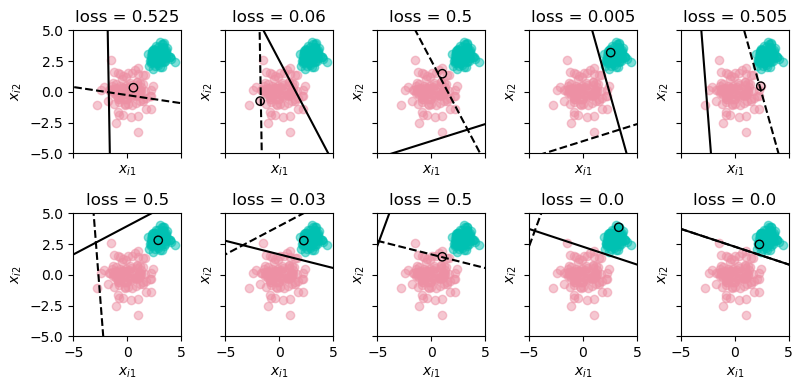

In [6]:
#| fig-cap: Several iterations of the perceptron algorithm. In each panel, the dashed line is the hyperplane corresponding to the previous weight vector $\vw^{(t)}$, while the solid line is the hyperplane for the updated weight vector $\vw^{t+1}$. The empty circle is the point $i$ used in the update; only iterations in which $i$ was a mistake are shown, with the exception of the final two iterations (by which the algorithm has converged). The loss is computed as in @eq-loss. (The perceptron update itself takes place using a function called `perceptron_update` whose implementation I have intentionally hidden -- you'll implement a version yourself in a blog post!)
#| label: fig-demonstration



np.random.seed(123456)
w = np.random.rand(3)

plt.rcParams["figure.figsize"] = (8, 4)
fig, axarr = plt.subplots(2, 5, sharex = True, sharey = True)
for ax in axarr.ravel():
    ax.set(xlim = (-5, 5), ylim = (-5, 5))
    plot_scatter(X1, X2, X3, X4, ax, legend = False)
    draw_line(w, -10, 10, ax, color = "black", linestyle = "dashed")
    w, i, loss = perceptron_update(X, y, w)    
    ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black")
    draw_line(w, -10, 10, ax, color = "black")
    ax.set_title(f"loss = {loss}")
    
plt.tight_layout()

## Convergence of the Perceptron Algorithm

Is the perceptron algorithm guaranteed to terminate? And if so, is it guaranteed to find a weight vector $\tilde{\vw}$ that perfectly separates the two data classes? 

::: {.callout-note}
::: {#def-linear-separability }

## Linear Separability

A data set with feature matrix $\mX \in \R^{n\times k}$ and target vector $y\in \{0, 1\}$ is *linearly separable* if there exists a weight vector $\tilde{\vw}$ such that, for all $i \in [n]$, 

$$
\bracket{\tilde{\vw}, \tilde{\vx}_i} > 0 \Leftrightarrow y = 1\;. 
$$

:::
:::

Take a moment to convince yourself of the following: 

::: {.callout-tip} 
::: {#prp-nonconvergence}

## Nonconvergence of perceptron for nonseparable data

Suppose that $(\mX, \vy)$ is not linearly separable. Then, the perceptron update does not converge. Furthermore, at no iteration of the algorithm is it the case that $\cL(\tilde{\vw}) = 0$. 

:::
:::

It's not as obvious that, if the data *is* linearly separable, then the perceptron algorithm will converge to a correct answer. Perhaps surprisingly, this is also true: 

::: {.callout-tip} 
::: {#thm-perceptron-convergence}

## Convergence of perceptron for separable data

Suppose that $(\mX, \vy)$ is linearly separable. Then: 

- The perceptron algorithm converges in a finite number of iterations to a vector $\tilde{\vw}$ that separates the data.  
- During the running of the perceptron algorithm, the total number of updates made is no more than
$$\frac{2 + r(\mX)^2}{\gamma(\mX, \vy)}\;,$$

where $r(\mX) = \max_{i \in [n]} \norm{\vx_i}$ and $\gamma(\mX, \vy)$ is a geometric measure called the *margin* of how far apart the two label classes are. 

:::
:::

For a proof of @thm-perceptron-convergence, see p. 37-44 of @hardt2021patterns.  

## Close-out Activity


::: {.callout-warning} 


## Start Implementing the Perceptron Algorithm

Suppose that you have a `numpy.Array` `X` of features and an `np.Array` `y` of binary labels. Assume that `X` does NOT contain a column of `1`s; that is, it corresponds to $\mX$ rather than $\tilde{\mX}$ from the notes above. Additionally, Assume that the labels in `y` are `0`s and `1`s rather than `-1`s and `1`s. This is not the mathematically convenient setup, but is the one that is most frequently seen in machine learning software. 

At the board, write as much code as you can to achieve some of the following tasks. Please work with a partner. It's ok to pick and choose which of these to try; but you should work together (i.e. in conversation) rather than in parallel. 

1. Determine `n` (the number of data points) and `p` (the number of features) from `X`. 
2. Modify `X` into `X_` (which contains a column of `1`s and corresponds to $\tilde{\mX}$). This one I'll give you for free: 
```python
X_ = np.append(X, np.ones((X.shape[0], 1)), 1)
```
3. Modify `y` into an array `y_` of `-1`s and `1`s, corresponding to the version we use in the notes above. 
6. Initialize a random weight vector `w_` with appropriate dimensions, corresponding to $\tilde{\vw}^{(0)}$. 
4. Generate a random index `i` between `0` and `n-1`. 
5. Extract the `i`th row of `X_`, which corresponds to $\tilde{\vx}_i$.  
6. Compute $\ell_i^{(0)} = \bracket{\tilde{\vw}^{(0)}, \tilde{\vx}_i}$. 

These items will give you a head start on [the blog post](../assignments/blog-posts/blog-post-erm%202.html) in which you will construct a full implementation of the perceptron algorithm. 

:::
